# Preamble

pip install git+https://github.com/Mayitzin/ahrs.git

## Imports

In [1]:
import ahrs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from matplotlib.ticker import AutoMinorLocator, MaxNLocator
from matplotlib.dates import AutoDateFormatter, AutoDateLocator
from IPython.display import Image, Latex, clear_output
from scipy.spatial.transform import Rotation
from tqdm.auto import tqdm as tqdm
from scipy.signal import butter, lfilter, iirnotch
from scipy.fftpack import fft


tqdm.pandas(desc="Progress")

## Parameters

In [2]:
# Metadata
header_rows = 3
# engine='pyarrow'
engine = "python"
nrows = 1e10
input_file = "data_1722191746.csv"

## Load data

In [3]:
# Load data
df = pd.read_csv(input_file, header=header_rows, engine=engine, nrows=nrows)

In [4]:
df.drop(df[df["Data Source"].notna()].index, inplace=True)

In [5]:
df["_value"] = pd.to_numeric(df["_value"])

In [6]:
df["_time"] = pd.to_datetime(df["_time"], errors="coerce")

In [7]:
df.dropna(subset=["_value", "_time"], inplace=True)

In [8]:
df.drop_duplicates(subset=["_time", "_field"], keep="first", inplace=True)

In [9]:
data = (
    df[["_time", "_field", "_value"]]
    .set_index(["_time", "_field"])
    .unstack()
    .droplevel(0, axis=1)
    .dropna(how="all", axis=1)
    .dropna(how="all", axis=0)
)

In [10]:
data

_field,Acc x,Acc y,Acc z,B,DHT hum,DHT temp,G,Gyro x,Gyro y,Gyro z,Humidity,Intensity,Mag x,Mag y,Mag z,PDM,Pressure,Proximity,R,Temperature
_time,,,,,,,,,,,,,,,,,,,,
2024-07-28 18:35:48.133,-0.08,0.04,-1.00,0.0,40.8,27.3,255.0,2.20,2.20,2.50,38.95,255.0,48.80,94.14,12.17,-45.00,1007.63,0.0,0.0,33.49
2024-07-28 18:35:48.775,-0.08,0.04,-1.01,0.0,40.8,27.3,255.0,2.14,2.26,2.38,39.15,255.0,48.62,93.79,11.96,-51.00,1007.63,0.0,0.0,33.52
2024-07-28 18:35:49.651,-0.08,0.04,-1.00,0.0,40.8,27.3,255.0,2.26,2.26,2.50,38.92,255.0,48.80,94.08,12.76,27.00,1007.71,0.0,0.0,33.45
2024-07-28 18:35:50.415,-0.08,0.04,-1.00,0.0,40.8,27.3,255.0,2.14,2.26,2.50,38.99,255.0,48.39,93.70,12.33,55.25,1007.58,0.0,0.0,33.49
2024-07-28 18:35:50.595,-0.08,0.04,-1.00,0.0,40.8,27.3,255.0,2.14,2.14,2.44,38.95,255.0,48.49,93.70,12.16,7.00,1007.72,0.0,0.0,33.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-28 19:52:40.000,-0.08,0.04,-1.00,0.0,41.2,26.8,255.0,2.08,2.20,2.50,38.93,255.0,48.67,92.93,12.13,-35.50,1006.61,0.0,0.0,33.32
2024-07-28 19:52:41.000,-0.08,0.04,-1.00,0.0,41.2,26.9,255.0,2.14,2.26,2.62,38.97,255.0,48.25,93.42,11.84,-13.75,1006.60,0.0,0.0,33.34
2024-07-28 19:52:42.000,-0.08,0.04,-1.00,0.0,41.2,26.9,255.0,1.95,2.20,2.44,38.88,255.0,48.49,92.52,12.52,-37.50,1006.69,0.0,0.0,33.30


# IMU

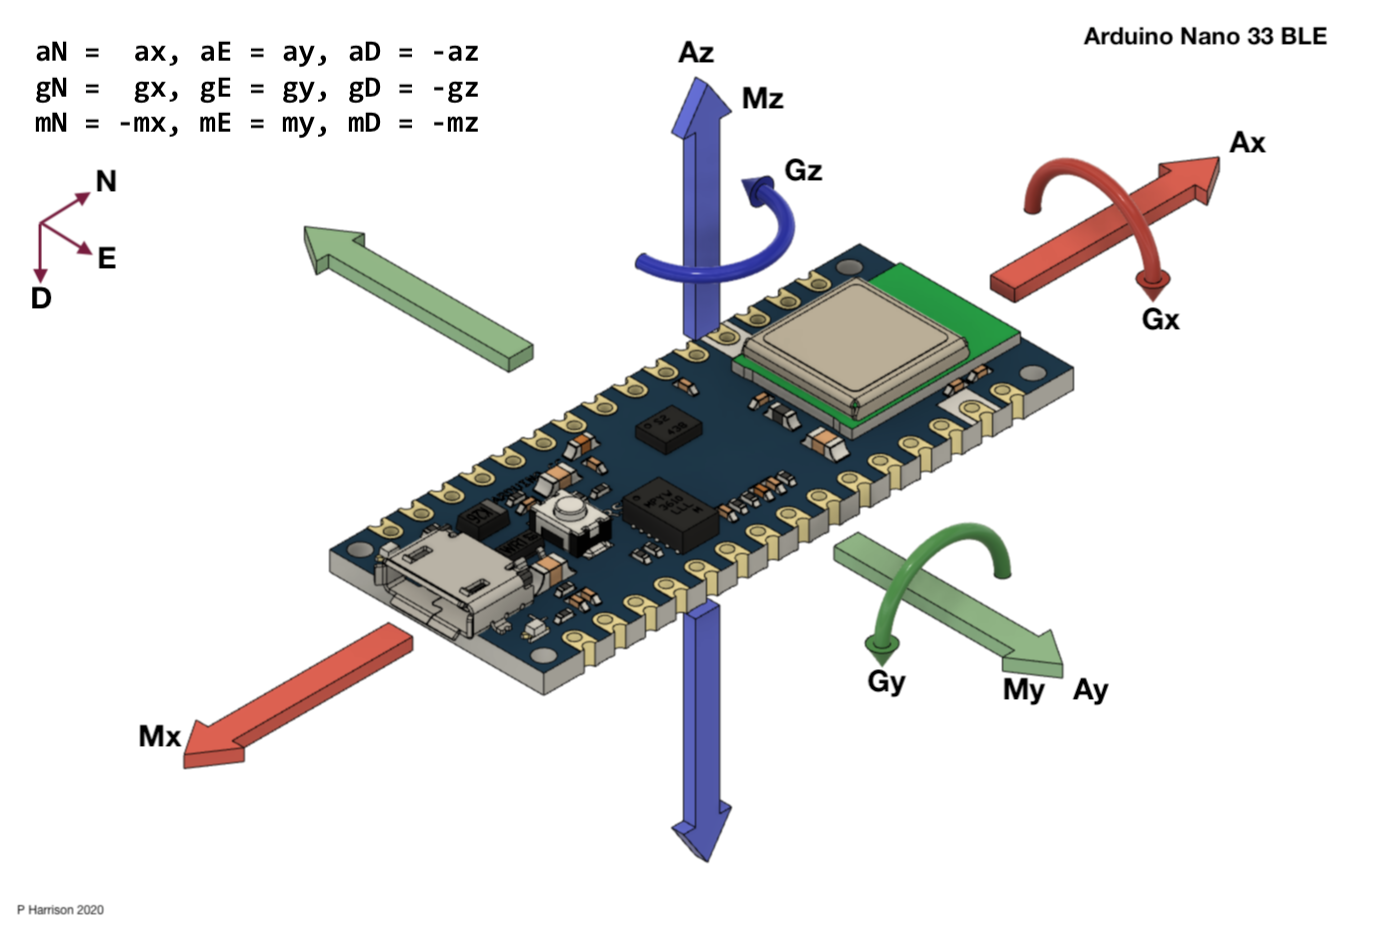

In [11]:
display(Image("Arduino_axis.PNG", retina=True))

Arduino coordinate conversion

Acc & Gyro: (x, y, z)->(y, x, z)

Mag: (x, y, z)->(y, -x, z)

Define right handed base with y pointing forward along the axis originally defined as Ax, x pointing right along the axis originally defined as Ay, and z vertical pointing upwards.

ahrs assumes x points North.

## Methods

In [12]:
def swap_xy(array):
    array[0], array[1] = array[1], array[0]
    return array


def flip_axis(array, axis):
    array[axis] = -array[axis]
    return array

In [13]:
# Plotting function
def plot_xyz(xyz):
    fig, axes = plt.subplots(
        2, 1, figsize=(12, 12), dpi=100, gridspec_kw={"height_ratios": [3, 1]}
    )

    fig.suptitle("Sense position", fontsize=16)

    xy = axes[0].scatter(xyz["px"], xyz["py"], c=xyz["pz"].values, marker=".", s=1)
    axes[0].scatter(0, 0, c="r", marker="x", label="Start")
    axes[0].scatter(
        xyz["px"].iloc[-1], xyz["py"].iloc[-1], c="g", marker="^", label="End"
    )
    axes[0].set_xlabel("East [m]", fontsize=14)
    axes[0].set_ylabel("North [m]", fontsize=14)
    axes[0].ticklabel_format(axis="both", style="sci", scilimits=(0, 0))
    axes[0].xaxis.set_major_locator(MaxNLocator(integer=True))

    c = plt.colorbar(xy, ax=axes[0])
    c.set_label("Height [m]", fontsize=14)
    c.ax.tick_params(labelsize=12)

    axes[1].axhline(0, c="g")
    axes[1].axhline(120, c="r")
    axes[1].plot(xyz["pz"], label="height")
    axes[1].set_xlabel("Time [s]", fontsize=14)
    axes[1].set_ylabel("Height [m]", fontsize=14)
    axes[1].xaxis.set_major_locator(AutoDateLocator())
    axes[1].tick_params(axis="x", labelrotation=45)
    # axes[1].set_ylim([0,120])

    for ax in axes:
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        ax.tick_params(axis="both", which="major", labelsize=12)
        ax.grid()
        ax.legend()

    fig.tight_layout()
    plt.show()


def plot_vectors(vectors):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection="3d")

    # Define the canonical basis vectors
    basis_vectors = np.identity(3)

    # Plot the basis vectors as lines from the origin
    for basis_vector in basis_vectors:
        ax.quiver(
            0,
            0,
            0,
            basis_vector[0],
            basis_vector[1],
            basis_vector[2],
            color="k",
            arrow_length_ratio=0.1,
        )

    # Extract the vector components
    for i, vector in enumerate(vectors):
        x, y, z = vector

        # Plot the vector as an arrow from the origin
        ax.quiver(0, 0, 0, x, y, z, color="r", arrow_length_ratio=0.1)

        # Add an annotation to the tip of the arrow
        ax.text(x, y, z, "XYZ"[i], color="red")

    # Set labels and limits
    ax.set_xlabel("E")
    ax.set_ylabel("N")
    ax.set_zlabel("Z")
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])

    ax.set_box_aspect(None, zoom=0.9)

    fig.tight_layout()

    plt.show()

In [14]:
# Vector rotation functions
def compute_rotation(v1, v2):
    # Normalize the input vectors
    v1_norm = v1 / np.linalg.norm(v1)
    v2_norm = v2 / np.linalg.norm(v2)

    # Calculate the axis of rotation
    axis_x = np.cross(v1_norm, v2_norm)
    axis_y = np.cross(v1_norm, axis_x)

    # Calculate the angle of rotation
    # angle = np.arccos(np.dot(v1_norm, v2_norm))

    # R = Rotation.from_rotvec(axis_x*angle, degrees=False)
    R = Rotation.align_vectors(
        [v1_norm, axis_y], [v2_norm, [-np.sign(v1_norm[2]), 0, 0]]
    )[0]

    return R


def update_rotation(gyro, prev_rotation):
    new_rotation = Rotation.from_rotvec(gyro, degrees=False)

    # Update rotation matrix using the previous rotation matrix
    updated_rotation = new_rotation * prev_rotation

    return updated_rotation

In [15]:
wgs = ahrs.utils.WGS()
madgwick = ahrs.filters.Madgwick()

# Universal constants
lat = 53.48
g = 9.80665

normal_versor = np.array([0.0, 0.0, 1.0])
normal_unit = wgs.normal_gravity(lat)
normal = normal_versor * normal_unit / g

# Resolution constants
accelerometer_resolution = 0.122 * 1e-3
gyroscope_resolution = 70 * 1e-3
magnetometer_resolution = 14 * 1e-3

# Calibration constants
initial_orientation = Rotation.identity().as_quat()
accelerometer_offsets = np.array([0.0, 0.0, 0.0])
gyroscope_offsets = np.array([0.0, 0.0, 0.0])
magnetometer_offsets = np.array([0.0, 0.0, 0.0])


def calibrate_sensors(sensor_data, start=1, window=10, plot=False):
    global initial_orientation
    global accelerometer_offsets
    global gyroscope_offsets
    global magnetometer_offsets

    begin = sensor_data.index[0] + pd.Timedelta(seconds=start)
    end = begin + pd.Timedelta(seconds=window)
    offsets = sensor_data.loc[begin:end]
    dt = np.diff(sensor_data.loc[begin:end].index) / pd.Timedelta(seconds=1)
    described = offsets.describe().T
    median_offsets = described["50%"]
    described["Error"] = described["std"] / described["mean"]
    print(f"Raw offsets:\n{described.to_string()}\n")

    raw_acc_array = offsets[
        ["Acc x", "Acc y", "Acc z"]
    ].to_numpy()  # Raw accelerometer readings

    normal = raw_acc_array.mean(axis=0) / np.linalg.norm(raw_acc_array.mean(axis=0))

    accelerometer_offsets = raw_acc_array.mean(axis=0)  # -normal

    raw_gyro_array = offsets[
        ["Gyro x", "Gyro y", "Gyro z"]
    ].to_numpy()  # Raw gyroscope readings

    gyroscope_offsets = raw_gyro_array.mean(axis=0)

    raw_mag_array = offsets[
        ["Mag x", "Mag y", "Mag z"]
    ].to_numpy()  # Raw gyroscope readings

    magnetometer_offsets = raw_mag_array.mean(axis=0)

    print(f"Accelerometer offsets: {accelerometer_offsets} g")

    print(f"Gyroscope offsets: {gyroscope_offsets} deg/s")

    print(f"Magnetometer offsets: {magnetometer_offsets} uT")

In [16]:
def process_sensor_data(sensor_data, start=pd.Timedelta(seconds=0)):
    position_list = [
        np.array([0.0, 0.0, 0.0])
    ]  # List to store the calculated positions
    velocity_list = [np.array([0.0, 0.0, 0.0])]
    acceleration_list = [np.array([0.0, 0.0, 0.0])]

    start = sensor_data.index[0] + start
    sensor_data = sensor_data.loc[start:]

    for idx, (timestamp, row) in enumerate(
        tqdm(sensor_data.iterrows(), total=sensor_data.shape[0])
    ):
        ax = row["Acc x"]
        ay = row["Acc y"]
        az = row["Acc z"]
        wx = row["Gyro x"]
        wy = row["Gyro y"]
        wz = row["Gyro z"]
        mx = row["Mag x"]
        my = row["Mag y"]
        mz = row["Mag z"]

        acc = (
            np.array([ax, ay, az]) - accelerometer_offsets
        )  # Raw acceleration readings
        acc = swap_xy(acc)  # Need to swap x and y to form right handed basis

        gyro = np.array([wx, wy, wz])  # - gyroscope_offsets  # Raw gyro readings
        gyro = swap_xy(gyro)  # Need to swap x and y to form right handed basis
        gyro = np.radians(gyro)

        mag = np.array(
            [mx, my, mz]
        )  # - magnetometer_offsets  # Raw magnetometer readings
        mag = (
            flip_axis(swap_xy(mag), 1) * 1e-3
        )  # uT -> nT # Need to swap x and y and flip y to form right handed basis

        if idx == 0:
            # Initialize first timestamp and rotation matrix
            prev_timestamp = timestamp
            prev_orientation = initial_orientation
            prev_acc = acc
            prev_gyro = gyro
            prev_mag = mag

            continue

        if all(abs(acc - prev_acc) < accelerometer_resolution):
            mean_acc = prev_acc
        else:
            mean_acc = (acc + prev_acc) / 2
            prev_acc = acc

        if all(abs(gyro - prev_gyro) < gyroscope_resolution):
            mean_gyro = prev_gyro
        else:
            mean_gyro = (gyro + prev_gyro) / 2
            prev_gyro = gyro

        if all(abs(mag - prev_mag) < magnetometer_resolution):
            mean_mag = prev_mag
        else:
            mean_mag = (mag + prev_mag) / 2
            prev_mag = mag

        # Convert timestamp to time in seconds
        dt = (timestamp - prev_timestamp) / pd.Timedelta(seconds=1)
        prev_timestamp = timestamp

        orientation = madgwick.updateMARG(
            q=prev_orientation, acc=mean_acc, mag=mean_mag, gyr=mean_gyro, dt=dt
        )
        prev_orientation = orientation
        rotation = Rotation.from_quat(orientation)
        rotation = update_rotation([0, 0, -np.pi / 2], rotation)

        # Rotate the linear acceleration vector into the canonical XYZ coordinates
        rotated_acceleration = rotation.apply(mean_acc)

        # Remove normal component from acceleration
        acceleration = rotated_acceleration  # - normal_versor  # * normal_unit #m/s^2
        acceleration_list.append(acceleration)

        # Integrate the rotated linear acceleration to determine velocity
        velocity = np.mean(acceleration_list[-2:], axis=0) * dt + velocity_list[-1]
        velocity_list.append(velocity)

        # Integrate velocity to determine position
        position = np.mean(velocity_list[-2:], axis=0) * dt + position_list[-1]
        position_list.append(position)

    # Create a pandas DataFrame from the positions list
    df_data = np.concatenate((acceleration_list, velocity_list, position_list), axis=1)
    df_columns = [i + j for i in "avp" for j in "xyz"]
    df = pd.DataFrame(df_data, columns=df_columns, index=sensor_data.index)

    plot_vectors(rotation.as_matrix().T)

    rotated_mag = rotation.apply(mean_mag) * 1e6  # uT -> T to avoid numeric errors

    return df

## Process data

In [17]:
from scipy.signal import butter, filtfilt

fs = 1


def low_pass_filter(data, cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype="low", analog=False)
    filtered_data = filtfilt(b, a, data)
    return filtered_data


def high_pass_filter(data, cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype="high", analog=False)
    filtered_data = filtfilt(b, a, data)
    return filtered_data


def band_pass_filter(data, lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype="band", analog=False)
    filtered_data = filtfilt(b, a, data)
    return filtered_data


def moving_average_filter(data, window_size):
    return np.convolve(data, np.ones(window_size) / window_size, mode="valid")


# # Assume gyro_x contains your gyroscope data and fs is your sampling frequency

# # Low-Pass Filter
# low_passed = low_pass_filter(data["Gyro x"], cutoff=0.1, fs=fs)

# # High-Pass Filter
# high_passed = high_pass_filter(data["Gyro x"], cutoff=0.01, fs=fs)

# # Band-Pass Filter
# band_passed = band_pass_filter(data["Gyro x"], lowcut=0.01, highcut=0.1, fs=fs)

# # Moving Average Filter
# moving_avg = moving_average_filter(data["Gyro x"], window_size=10)

In [18]:
# filtered_gyro = data.filter(like="Gyro").apply(low_pass_filter, cutoff=0.1, fs=fs)
# filtered_gyro = data.filter(like="Gyro").apply(high_pass_filter, cutoff=0.01,fs=fs)
for column in data.filter(like="Gyro"):
    data[column] = low_pass_filter(data[column], cutoff=0.1, fs=fs)
    data[column] = high_pass_filter(data[column], cutoff=0.01, fs=fs)
    # data[column] = moving_average_filter(data[column], window_size=10)


for column in data.filter(like="Mag"):
    data[column] = low_pass_filter(data[column], cutoff=0.1, fs=fs)
    data[column] = high_pass_filter(data[column], cutoff=0.01, fs=fs)
    # data[column] = moving_average_filter(data[column], window_size=10)

In [19]:
calibrate_sensors(data, start=1, window=10)

Raw offsets:
             count         mean           std          min          25%          50%          75%          max         Error
_field                                                                                                                      
Acc x         14.0    -0.080000  1.440166e-17    -0.080000    -0.080000    -0.080000    -0.080000    -0.080000 -1.800208e-16
Acc y         14.0     0.040000  7.200831e-18     0.040000     0.040000     0.040000     0.040000     0.040000  1.800208e-16
Acc z         14.0    -1.000000  0.000000e+00    -1.000000    -1.000000    -1.000000    -1.000000    -1.000000 -0.000000e+00
B             14.0     0.000000  0.000000e+00     0.000000     0.000000     0.000000     0.000000     0.000000           NaN
DHT hum       14.0    40.750000  5.188745e-02    40.700000    40.700000    40.750000    40.800000    40.800000  1.273312e-03
DHT temp      14.0    27.342857  5.135526e-02    27.300000    27.300000    27.300000    27.400000    27.400000  

In [20]:
smooth_data = (
    data.rolling(window=5, min_periods=1, center=True).median().drop_duplicates()
)

  0%|          | 0/5408 [00:00<?, ?it/s]

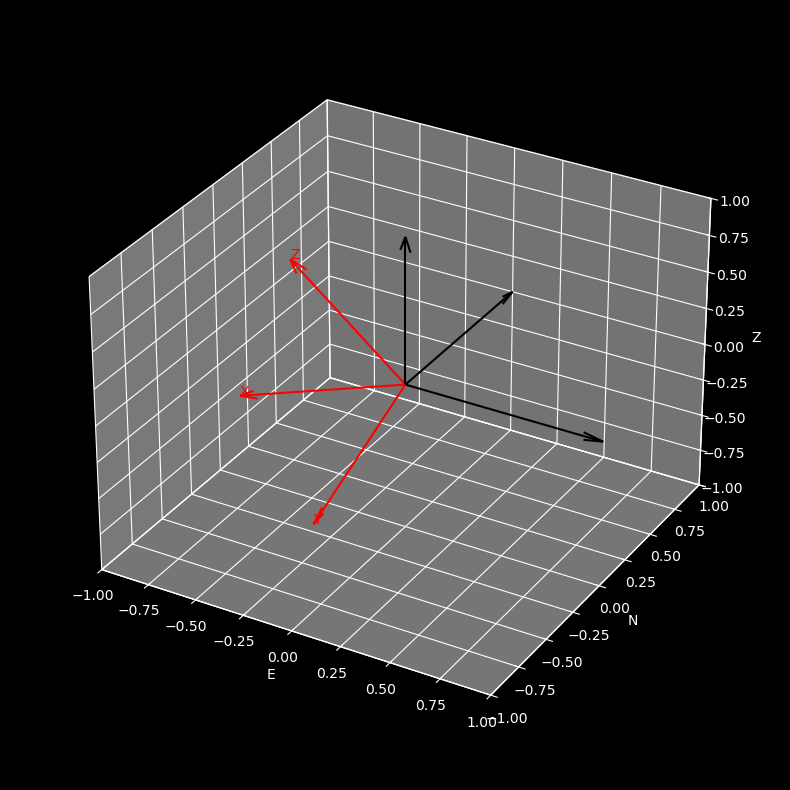

In [21]:
xyz = process_sensor_data(smooth_data, start=pd.Timedelta(seconds=0))
# xyz = process_sensor_data(data, start=pd.Timedelta(seconds=0))

## Acceleration

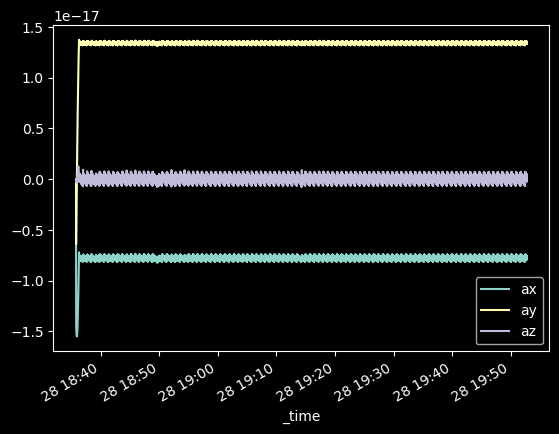

In [22]:
xyz.filter(like="a").plot()
plt.show()

In [23]:
xyz.filter(like="a").mean()

ax   -7.841227e-18
ay    1.333267e-17
az    1.176432e-20
dtype: float64

ax    0.114569
ay    0.001542
az   -0.006795
dtype: float64

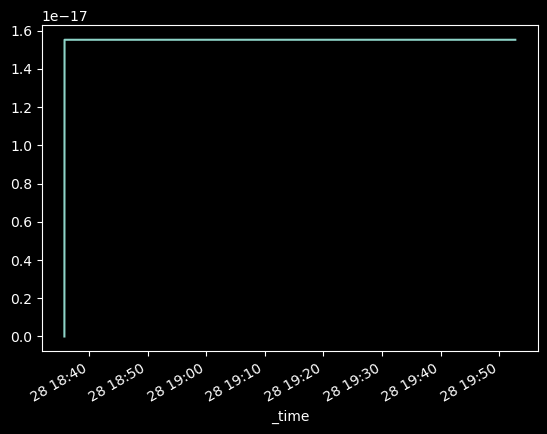

In [24]:
xyz.filter(like="a").apply(np.linalg.norm, axis=1).plot()
plt.show()

## Velocity

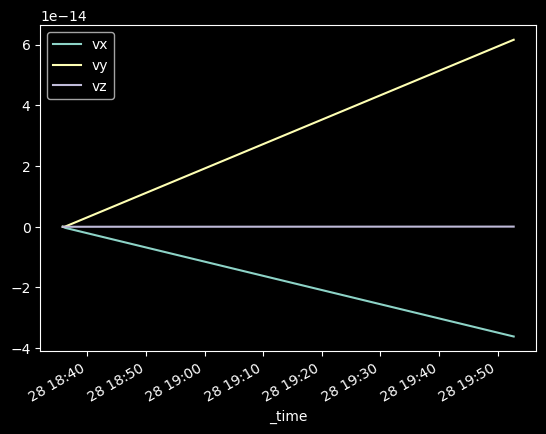

In [25]:
xyz.filter(like="v").plot()
plt.show()

In [26]:
xyz.filter(like="v").sum()

vx   -9.097554e-11
vy    1.534445e-10
vz    1.373486e-13
dtype: float64

## Position

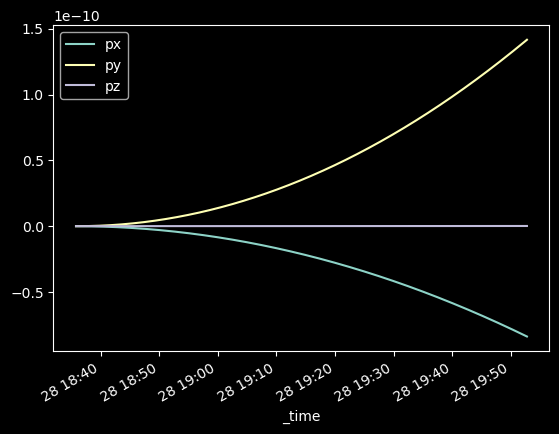

In [27]:
xyz.filter(like="p").plot()
plt.show()

In [28]:
xyz.filter(like="p").sum()

px   -1.355500e-07
py    2.267105e-07
pz    2.116017e-10
dtype: float64

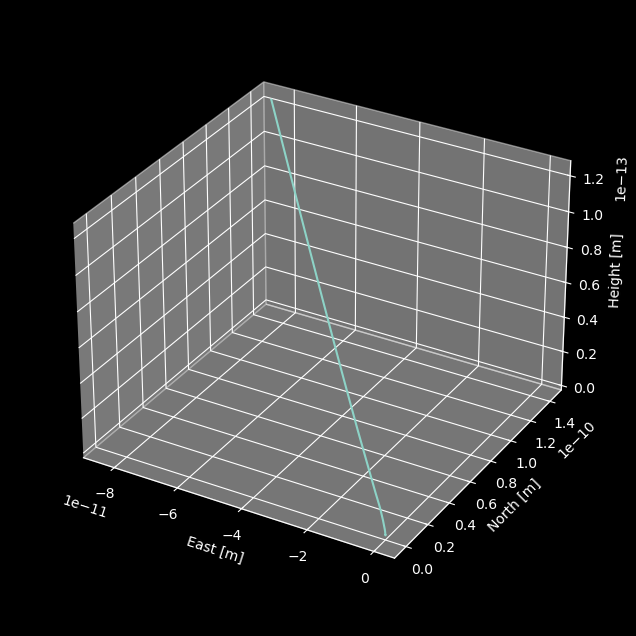

In [29]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.plot(xyz["px"], xyz["py"], xyz["pz"])
ax.set_xlabel("East [m]")
ax.set_ylabel("North [m]")
ax.set_zlabel("Height [m]")
ax.ticklabel_format(axis="both", style="sci", scilimits=(0, 0))
# ax.set_aspect("equal", adjustable='box')
ax.set_box_aspect(None, zoom=0.9)
plt.show()

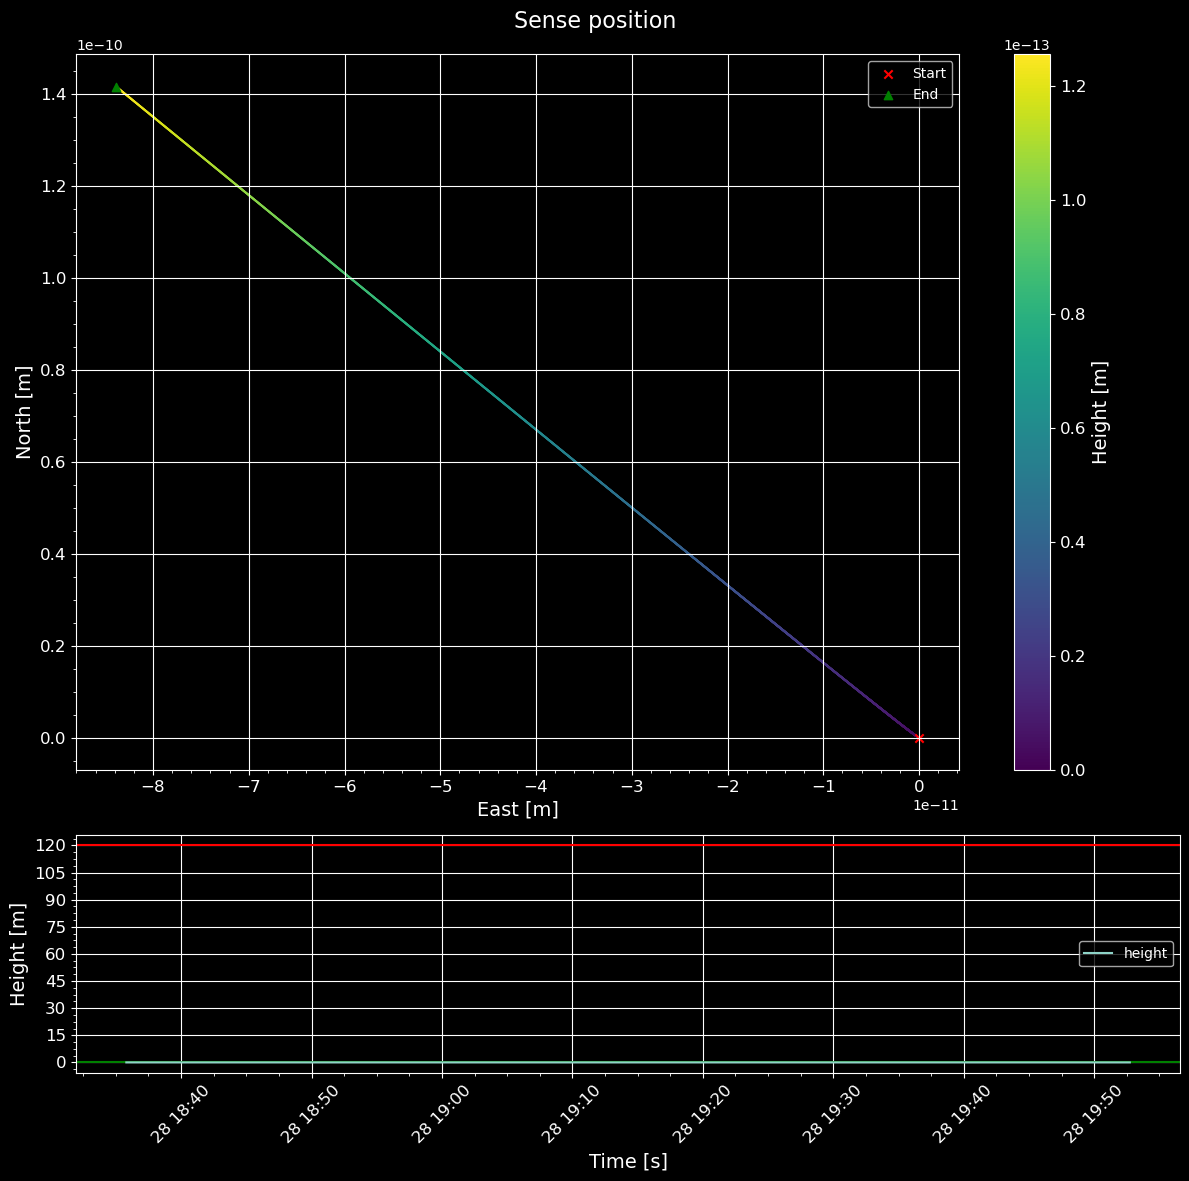

In [30]:
plot_xyz(xyz)

## Raw data 

### Accelerometer

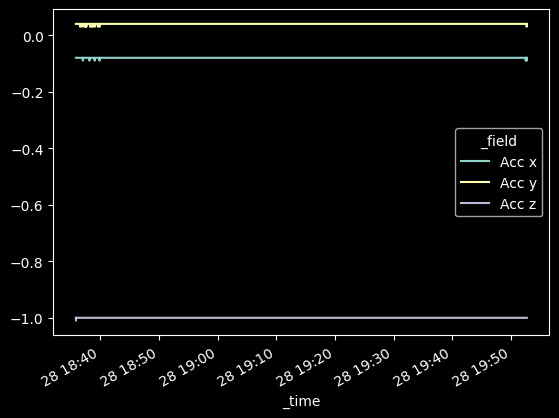

In [68]:
data.filter(like="Acc ").plot()
plt.show()

In [ ]:
data.filter(like="Acc").apply(np.linalg.norm, axis=1).plot()
plt.show()

### Gyroscope

In [ ]:
data.filter(like="Gyro ").plot()
plt.show()

In [ ]:
data.filter(like="Gyro ").mean()

In [ ]:
data.filter(like="Gyro").apply(np.linalg.norm, axis=1).plot()
plt.show()

### Magnetometer

In [ ]:
data.filter(like="Mag").plot()
plt.show()

In [ ]:
data.filter(like="Mag").apply(np.linalg.norm, axis=1).plot()
plt.show()